In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### pip 설치

In [ ]:
! pip install mxnet
! pip install gluonnlp==0.8.0
! pip install tqdm pandas
! pip install sentencepiece
! pip install transformers
! pip install torch
! pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
! pip install koco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 34.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292697 sha256=0c852cd1bbabbda2f7dcc7ca6b7706d1559deff706c128b12295aba24da7a35f
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.9 MB/s eta 0:00:00
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-g8oloibw/kobert-tokenizer_f79dd961ede64ddab4ffbaea57351d6d
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-g8oloibw/kobert-tokenizer

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
## CPU
#device = torch.device("cpu")

## GPU



device = torch.device("cuda:0")
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

### 데이터 불러오기

In [ ]:
!git clone https://github.com/2runo/Curse-detection-data.git

Cloning into 'Curse-detection-data'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 16 (delta 4), reused 2 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 253.84 KiB | 7.69 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
f = open(r'/content/Curse-detection-data/dataset.txt')
lines = f.readlines()
train_data = []
# 비속어가 1
for line in lines:
    data_documents = []

    line = line.strip()
    label = int(line[-1])
    input = line[:-1].replace("|","")

    data_documents.append(input)
    data_documents.append(label)
    train_data.append(data_documents)
f.close()

### 데이터 전처리
- 토크나이징 하기 위한 전처리
- 토크나이징

In [ ]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(train_data, test_size=0.1, random_state=42)

In [ ]:
# documents_train[0]

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        # print(transform([dataset[0][sent_idx]]))
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
class BERTSentenceTransform:
    """BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [ ]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 30
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

In [ ]:
data_train.sentences[0]

(array([   2, 2007, 7383, 6705, 5702, 7063,  463,  517,    0,    3,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(10, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32))

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

### 모델 생성

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)


In [ ]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
train_losses = []
train_accuracies = []
test_accuracies = []
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    epoch_loss = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        epoch_loss += loss.item()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    avg_train_acc = train_acc / (batch_id+1)
    train_accuracies.append(avg_train_acc)
    avg_epoch_loss = epoch_loss / (batch_id+1)

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    train_losses.append(avg_epoch_loss)
    avg_test_acc = test_acc / (batch_id+1)
    test_accuracies.append(avg_test_acc)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-21-c177e89554db>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.7767730951309204 train acc 0.40625
epoch 1 train acc 0.6027320752733389


<ipython-input-21-c177e89554db>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1 test acc 0.7196428571428571


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.5493150949478149 train acc 0.78125
epoch 2 train acc 0.771794838099243


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2 test acc 0.7821428571428571


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.392368346452713 train acc 0.796875
epoch 3 train acc 0.8576009251471826


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 3 test acc 0.7834821428571429


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.2056044638156891 train acc 0.9375
epoch 4 train acc 0.9115656539108494


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4 test acc 0.7852678571428571


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.22537073493003845 train acc 0.921875
epoch 5 train acc 0.9404502207737594


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 5 test acc 0.8357142857142857


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.2155398577451706 train acc 0.921875
epoch 6 train acc 0.9483415685449957


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 6 test acc 0.8183035714285714


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.13081184029579163 train acc 0.96875
epoch 7 train acc 0.9790396341463414


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 7 test acc 0.8167410714285713


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.123499296605587 train acc 0.96875
epoch 8 train acc 0.9744664634146342


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 8 test acc 0.8089285714285713


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.09519726037979126 train acc 0.984375
epoch 9 train acc 0.9817073170731707


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 9 test acc 0.8136160714285714


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.10742920637130737 train acc 0.96875
epoch 10 train acc 0.980334051724138


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 10 test acc 0.8622767857142858


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.1653921902179718 train acc 0.953125
epoch 11 train acc 0.9862410639192599


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 11 test acc 0.86875


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.15376214683055878 train acc 0.96875
epoch 12 train acc 0.9887576219512195


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 12 test acc 0.8450892857142858


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.2681468725204468 train acc 0.921875
epoch 13 train acc 0.9864710365853658


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 13 test acc 0.8578125


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.1496119350194931 train acc 0.96875
epoch 14 train acc 0.9954268292682927


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 14 test acc 0.859375


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.06341443955898285 train acc 0.96875
epoch 15 train acc 0.9965701219512195


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 15 test acc 0.871875


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.0014070664765313268 train acc 1.0
epoch 16 train acc 0.9958079268292683


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 16 test acc 0.86875


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.0005266567459329963 train acc 1.0
epoch 17 train acc 0.9979039634146342


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 17 test acc 0.8607142857142858


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.008770429529249668 train acc 1.0
epoch 18 train acc 0.999047256097561


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 18 test acc 0.878125


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.0004901086213067174 train acc 1.0
epoch 19 train acc 0.999047256097561


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 19 test acc 0.8671875


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.001035911263898015 train acc 1.0
epoch 20 train acc 0.9984756097560976


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 20 test acc 0.8734375


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.00020687581854872406 train acc 1.0
epoch 21 train acc 0.9982850609756098


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 21 test acc 0.8575892857142857


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.00021797232329845428 train acc 1.0
epoch 22 train acc 0.999047256097561


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 22 test acc 0.8575892857142857


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.0009021952282637358 train acc 1.0
epoch 23 train acc 0.9996189024390244


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 23 test acc 0.8765625


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.0003138372558169067 train acc 1.0
epoch 24 train acc 0.9994283536585366


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 24 test acc 0.8765625


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.0001575232163304463 train acc 1.0
epoch 25 train acc 0.9996189024390244


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 25 test acc 0.8765625


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.00014337518950924277 train acc 1.0
epoch 26 train acc 0.9992378048780488


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 26 test acc 0.871875


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.0002011733886320144 train acc 1.0
epoch 27 train acc 0.9992378048780488


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 27 test acc 0.8734375


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.00013978600327391177 train acc 1.0
epoch 28 train acc 0.9996189024390244


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 28 test acc 0.8734375


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.00015007994079496711 train acc 1.0
epoch 29 train acc 0.9996189024390244


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 29 test acc 0.8734375


  0%|          | 0/82 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.001312918378971517 train acc 1.0
epoch 30 train acc 0.9994283536585366


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 30 test acc 0.8734375


### 모델 저장

In [ ]:
# 모델 저장하기
model_path = "/content/drive/MyDrive/Colab Notebooks/model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Colab Notebooks/model.pth


### 모델 평가

##### loss & accuracy graph

In [ ]:
import matplotlib.pyplot as plt

1. loss 함수 그래프

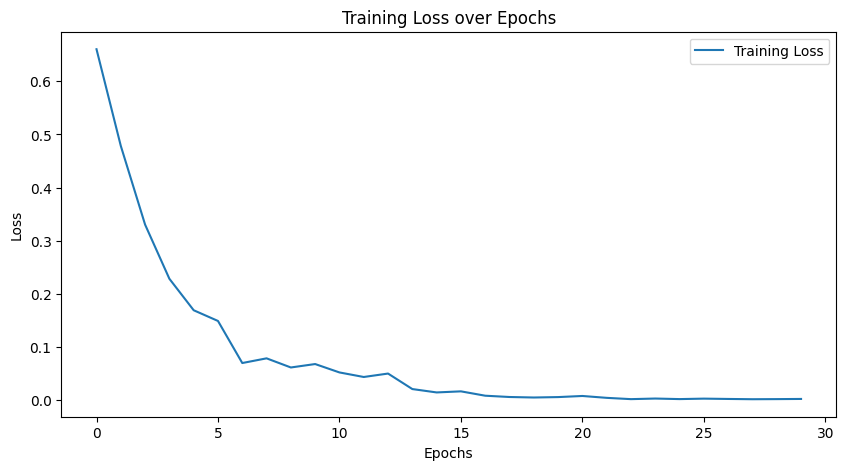

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

2. 정확도 그래프 그리기


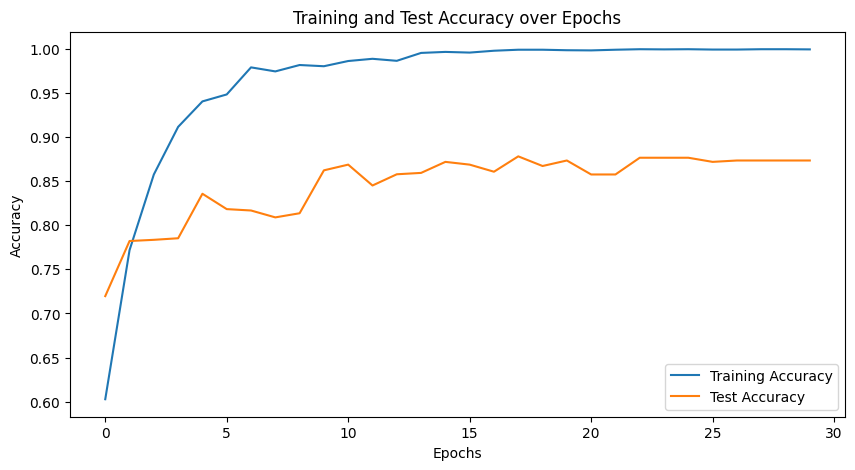

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()

In [ ]:
print(model)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

##### kobert model parameter

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 92188418
Number of trainable parameters: 92188418


##### 모델 출력 및 속도 측정

In [ ]:
# def model_predict(text, model):
#     model.eval()
#     torch_text = tokenizer(text)
#     token_ids =torch.Tensor(torch_text['input_ids']).int().to(device)
#     print(token_ids)
#     segment_ids = torch.Tensor(torch_text['token_type_ids']).to(device)
#     valid_length= torch.Tensor(torch_text['attention_mask']).long().unsqueeze(1)
#     print(valid_length)
#     # label = torch_text['label'].long().to(device)

#     out = model(token_ids, valid_length, segment_ids)
#     return out

In [ ]:
def modelpredict(predict_sentence):
    data = [predict_sentence, '0']
    dataset_another = [data]
    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_eval=[]
        k = []
        #k.append(out.reshape(-1,1))
        #k.append(1-out.reshape(-1,1))
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
            if np.argmax(logits) == 0:
                test_eval.append(predict_sentence)
            elif np.argmax(logits) == 1:
                test_eval.append("비속어가 속해 있습니다")
            elif np.argmax(logits) == 2:
                test_eval.append(f"{predict_sentence} -> hate 문장입니다")
        print(np.argmax(logits))
        print(test_eval[0])
        #print(out)
        #print(type(out))
    #return k

In [ ]:
type(modelpredict("씨발 너 정말 개새끼 녀석이구나"))

1
비속어가 속해 있습니다


NoneType

In [ ]:
modelpredict("죽어")

1
비속어가 속해 있습니다


In [ ]:
data_timer = [""]

In [ ]:
len(dataset_test)

583

In [ ]:
%%time
for i in range(len(dataset_test)):
    modelpredict(dataset_test[i][0])

0
일본은 이미 30%가 노인인 세계1위 노인국이다(한국은 2040년쯤 달성될예정)  그러니까 한국이 정확히 일본의 20년 뒤를 밟고 있는거지..일할수밖에 없음 전체인구의 3분의1이 논다는건 국가적으로 엄청난 손해임 
0
이갈로>까꿍이
1
비속어가 속해 있습니다
0
근데 머리가 나빠서 공부 못하면 기능은 더 못할 확률 높음
0
4년쯤 전인데 그 다음날 sk해지하고 lg로 갈아탐
0
그리즈만 닮은 애네. 엑소도 활동할만큼 했으니 미련 없을듯
0
ㅋㅋㅋㅋㅋㅋ 훨 낫네
0
팬티..꼬쟁이..
0
익명 게시판은 거르는게 답
1
비속어가 속해 있습니다
0
푸헬헬
0
닭
0
이승만 각하하고 무슨 상관이노ㅋㅋ
1
비속어가 속해 있습니다
1
비속어가 속해 있습니다
1
비속어가 속해 있습니다
1
비속어가 속해 있습니다
0
280원 ㅇㅂ
0
쓰레기
0
참고로,울나라 현궁도 비슷하게 생겻어요.
1
비속어가 속해 있습니다
0
미안해 ㅠㅠ 잘 먹을게
0
지자체 사람들은 그 동네 살겠지만, 그래도 그 사람들 그 지역에서 중심이 되는 시 단위에서 산다. 거기서 살면서 자기 근무지로 출퇴근하는거지. 
0
현금이 많으면 노인들 죽었을때 청소업체에서 꿀꺽하는돈도 많겠네 개꿀
1
비속어가 속해 있습니다
0
아이러니한게 어릴때부터 영어공부해오면서 좋은 글을 영어로만 많이봐서 영어쓸땐 고상하다는 소리많이듣는데
1
비속어가 속해 있습니다
1
비속어가 속해 있습니다
0
일베줬다. 티비 밑에 받침대 정보좀 줘. 어디꺼임?
0
먹는건 어쩔수 없음 자연의 섭리니까
0
드래곤볼gt랑 슬램덩크때문에 알게된 내가 좋아하는 유일한 일본인.. 안타깝더라
0
저열한 민족성   미국 이승만 박정희라는 변수가 있어서  본래  민족 모습을 잠시 벗어난거였지   원래 우리 민족 본 모습은 북괴임     다시 그길로 가는게 보이잖아
0
반응은 어떠냐?
1
비속어가 속해 있습니다
0
이런 포맷?
1
비속어가 속해 있습니다
0
전씨는?
1
비속어가 속해 있습니다
1
비속어가 속해 있습니다
0
사드 ㄷㄷㄷㄷㄷㄷㄷ
1
비속어가 속해 